In [1]:
import numpy as np
from math import log2
import copy
import pandas as pd

In [2]:
df = pd.read_csv("D3leaves.txt", sep=" ", header=None)
#df = pd.read_csv("Druns.txt", sep=" ", header=None)
df.columns = ['x1', 'x2', 'Outcome']
cols = df.columns   
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [3]:
df

,x1,x2,Outcome
0,10,1,1
1,10,2,1
2,10,3,1
3,1,1,0
4,1,3,1


In [4]:
def entropy(data):
    count = len(data)
    outcome = list(data["Outcome"])
    p0 = sum(b == 1 for b in outcome) / count
    p1 = 1 - p0
    
    proba = [float(p0), float(p1)]
    proba[0] /= sum(proba)
    proba[1] /= sum(proba)
    if proba[0] == 0 or proba[1] == 0:
        I = 0
    else:
        I = -1 * np.dot(proba, np.log2(proba))
    return I

In [5]:
entropy(df)

0.7219280948873623

In [6]:
def info_gain(df, fea, threshold):  # x_fea <= threshold;  fea = 2,3,4,..., 10; threshold = 1,..., 9
    count = len(df)
    d1 = df[df[fea] < threshold]
    d2 = df[df[fea] >= threshold]
    if len(d1) == 0 or len(d2) == 0: 
        #print(fea + ">=" + str(threshold) + ": IG: 0" + " Gain Ratio: inf")
        return 0
    
    df_list = [d1,d2]
    remainder = float(0)
    Intrinsic_info = float(0)
    for df_sub in df_list:
            if df_sub.shape[0] >= 1:
                remainder_add = float(df_sub.shape[0]/count) * entropy(df_sub)
                intrinsic_add = float(-1*df_sub.shape[0]/count)*np.log2(df_sub.shape[0]/count)
                remainder += remainder_add
                Intrinsic_info += intrinsic_add
                         
    infoGain = entropy(df)- remainder
    gain_ratio = infoGain /Intrinsic_info
    #print(fea + ">=" + str(threshold) + ": IG: " + str(infoGain)+ " Gain Ratio: " + str(gain_ratio))
    return infoGain

In [7]:
info_gain(df,'x2',8)
info_gain(df,'x2',7)
info_gain(df,'x2',6)
info_gain(df,'x2',5)
info_gain(df,'x2',4)
info_gain(df,'x2',3)
info_gain(df,'x2',2)
info_gain(df,'x2',1)
info_gain(df,'x2',0)
info_gain(df,'x2',-1)
info_gain(df,'x2',-2)
info_gain(df,'x1',0.1)
info_gain(df,'x1',0)


0

In [46]:
def find_best_split(data,fea):
    #find the feature that is interested
    vals = data[fea].tolist()
    vals = [float(x) for x in vals]
    #find the split with max infoGain
    max_ig = float("-inf")
    thres_val = 0
    
    for i in range(0, len(vals)):
            thres = vals[i]
            ig = info_gain(data, fea, thres)
            if ig >= max_ig:
                max_ig = ig
                thres_val = thres

    return thres_val

In [47]:
#choose feature
def choose_fea(df):
    max_info_gain = float("-inf")
    best_fea = None
    threshold = 0
    feature_list = list(df.columns)[:-1]
    
    for feature in feature_list:
        thres = find_best_split(df, feature)
        ig = info_gain(df, feature, thres)
        #print(str(feature) + " Feature, Threshold : " + str(thres) + " IG: " + str(ig) + " IG_Ratio: " + str(ig/entropy(df)))
        if ig > max_info_gain:
                max_info_gain = ig
                best_fea = feature
                threshold = thres
        
    return best_fea, threshold, max_info_gain

In [48]:
class Node():
    def __init__(self, feature, threshold, left_nums=0, right_nums=0, leaf_nums=0, ig=0):
        # Which column does it belong to
        self.attr = feature
        # What is the threshold value that led to its split
        self.thres = threshold

        self.left = None
        self.right = None

        # Demographic data at that node
        self.left_nums = 0
        self.right_nums = 0
        self.leaf_nums = 0

        # Is it a leaf
        self.leaf = False
        # Label assigned to a node if leaf
        self.predict = None
        self.ig = ig

In [49]:
def create_tree(data):
    #print("income data: " , data)
    
    outcome = list(data["Outcome"])
    p = sum(b == 1 for b in outcome)
    n = sum(b == 0 for b in outcome)
    #remaining data has only one kind of label remaining 
    if p == 0 or n == 0:
        # Create a leaf node indicating it's prediction
        leaf = Node(None,None)
        leaf.leaf = True
        if p >= n:
            leaf.predict = 1
        else:
            leaf.predict = 0
        leaf.leaf_nums = p+n
        return leaf
    else:
        #find the feature for splitting with threshold
        best_fea, threshold, ig = choose_fea(data)
        #create subtree
        tree = Node(best_fea, threshold, ig=ig)
        sub_1 = data[data[best_fea] >= threshold]
        sub_2 = data[data[best_fea] < threshold]
        
        #print("left_tree: " , sub_1)
        #print("right_tree: " , sub_2)
        #print()
        
        # Recursively build left and right subtree
        tree.left_nums = sub_1.shape[0]
        tree.right_nums = sub_2.shape[0]

        tree.left = create_tree(sub_1)
        tree.right = create_tree(sub_2)
        return tree
        
        

In [50]:
def print_tree(root):
    if (root.leaf):
        print('return ',root.predict)
    else:
        print('if （',root.attr,' >= ',root.thres,')')
        print_tree(root.left)
        
        print('else')
        print_tree(root.right)

In [51]:
tree = create_tree(df)
print()
print_tree(tree)


if （ x2  >=  0.201829 )
return  1
else
return  0


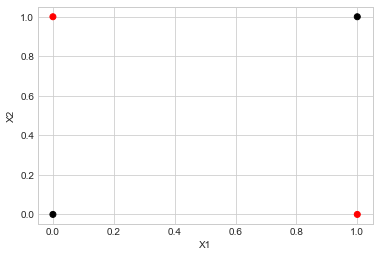

In [14]:
#2.2
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

plt.xlabel('X1')
plt.ylabel('X2')

plt.scatter([0, 0, 1, 1], [0, 1, 0, 1], color=['black','red','red','black'])

In [40]:
#2.5 & 2.6
data_d1 = pd.read_csv("D1.txt", sep=" ", header=None)
data_d1.columns = ['x1', 'x2', 'Outcome']
cols = data_d1.columns   
data_d1[cols] = data_d1[cols].apply(pd.to_numeric, errors='coerce')
d1_tree = create_tree(data_d1)
print_tree(d1_tree)

if （ x2  >=  0.201829 )
return  1
else
return  0


In [42]:
data_d2 = pd.read_csv("D2.txt", sep=" ", header=None)
data_d2.columns = ['x1', 'x2', 'Outcome']
cols = data_d2.columns   
data_d2[cols] = data_d2[cols].apply(pd.to_numeric, errors='coerce')
d2_tree = create_tree(data_d2)
print_tree(d2_tree)

if （ x1  >=  0.532965 )
if （ x2  >=  0.383147 )
if （ x1  >=  0.549173 )
return  1
else
if （ x2  >=  0.43617 )
return  1
else
return  0
else
if （ x1  >=  0.769265 )
if （ x2  >=  0.170162 )
return  1
else
if （ x1  >=  0.92936 )
if （ x2  >=  0.015756 )
return  1
else
return  0
else
if （ x2  >=  0.122877 )
if （ x1  >=  0.852791 )
return  1
else
return  0
else
return  0
else
if （ x2  >=  0.268859 )
if （ x1  >=  0.66058 )
if （ x2  >=  0.300402 )
return  1
else
if （ x1  >=  0.751571 )
return  1
else
return  0
else
return  0
else
return  0
else
if （ x2  >=  0.691233 )
if （ x1  >=  0.253787 )
return  1
else
if （ x2  >=  0.886446 )
if （ x1  >=  0.084845 )
return  1
else
if （ x2  >=  0.956678 )
return  1
else
return  0
else
if （ x1  >=  0.191498 )
if （ x2  >=  0.78283 )
return  1
else
return  0
else
if （ x2  >=  0.862496 )
if （ x1  >=  0.142654 )
return  1
else
return  0
else
return  0
else
if （ x2  >=  0.532699 )
if （ x1  >=  0.409632 )
if （ x1  >=  0.421394 )
return  1
else
if （ x1  >=  0.41518

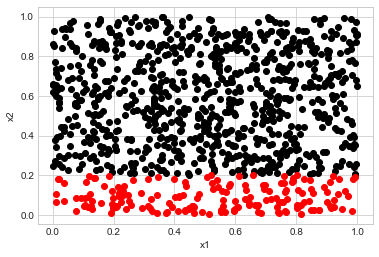

In [43]:
x_black = np.array(data_d1[data_d1['Outcome']==1]['x1'])
y_black = np.array(data_d1[data_d1['Outcome']==1]['x2'])
x_red = np.array(data_d1[data_d1['Outcome']==0]['x1'])
y_red = np.array(data_d1[data_d1['Outcome']==0]['x2'])

plt.xlabel('x1')
plt.ylabel('x2')

plt.plot(x_black, y_black, 'o', color='black')
plt.plot(x_red, y_red, 'o', color='red')

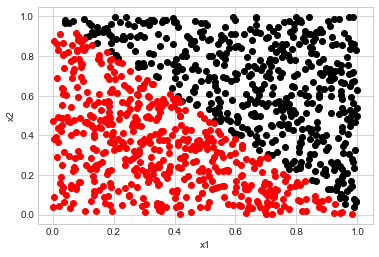

In [45]:
x_black = np.array(data_d2[data_d2['Outcome']==1]['x1'])
y_black = np.array(data_d2[data_d2['Outcome']==1]['x2'])
x_red = np.array(data_d2[data_d2['Outcome']==0]['x1'])
y_red = np.array(data_d2[data_d2['Outcome']==0]['x2'])

plt.xlabel('x1')
plt.ylabel('x2')

plt.plot(x_black, y_black, 'o', color='black')
plt.plot(x_red, y_red, 'o', color='red')

In [53]:
#2.7
df = pd.read_csv("Dbig.txt", sep=" ", header=None)
df.columns = ['x1', 'x2', 'Outcome']
cols = df.columns   
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

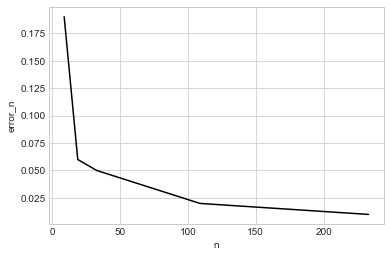

In [54]:
dbig_train = df.sample(n=8192)
df_test = df.loc[~df.index.isin(dbig_train.index)]
d32 = dbig_train[:32]
d128 = dbig_train[:128]
d512 = dbig_train[:512]
d2048 = dbig_train[:2048]
d8192 = dbig_train[:8192]

#error
n = [9, 19, 33, 109, 233]
err = [1-0.81, 1-0.94, 1-0.95, 1-0.98, 1-0.99]
plt.xlabel('n')
plt.ylabel('error_n')

plt.plot(n, err, '', color='black')

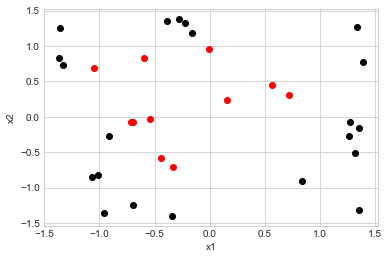

In [17]:
x_black = np.array(d32[d32['Outcome']==1]['x1'])
y_black = np.array(d32[d32['Outcome']==1]['x2'])
x_red = np.array(d32[d32['Outcome']==0]['x1'])
y_red = np.array(d32[d32['Outcome']==0]['x2'])

plt.xlabel('x1')
plt.ylabel('x2')

plt.plot(x_black, y_black, 'o', color='black')
plt.plot(x_red, y_red, 'o', color='red')


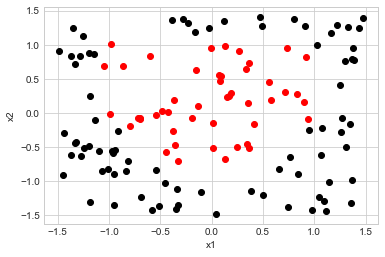

In [18]:
x_black = np.array(d128[d128['Outcome']==1]['x1'])
y_black = np.array(d128[d128['Outcome']==1]['x2'])
x_red = np.array(d128[d128['Outcome']==0]['x1'])
y_red = np.array(d128[d128['Outcome']==0]['x2'])

plt.xlabel('x1')
plt.ylabel('x2')

plt.plot(x_black, y_black, 'o', color='black')
plt.plot(x_red, y_red, 'o', color='red')

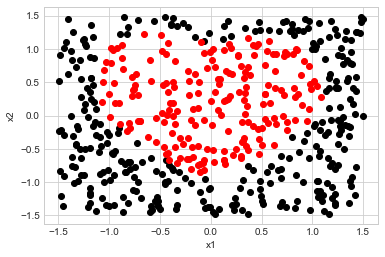

In [19]:
x_black = np.array(d512[d512['Outcome']==1]['x1'])
y_black = np.array(d512[d512['Outcome']==1]['x2'])
x_red = np.array(d512[d512['Outcome']==0]['x1'])
y_red = np.array(d512[d512['Outcome']==0]['x2'])

plt.xlabel('x1')
plt.ylabel('x2')

plt.plot(x_black, y_black, 'o', color='black')
plt.plot(x_red, y_red, 'o', color='red')

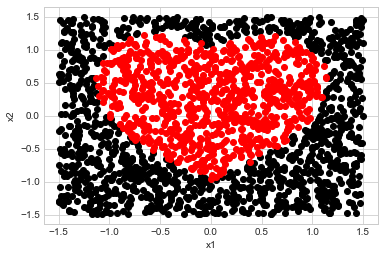

In [20]:
x_black = np.array(d2048[d2048['Outcome']==1]['x1'])
y_black = np.array(d2048[d2048['Outcome']==1]['x2'])
x_red = np.array(d2048[d2048['Outcome']==0]['x1'])
y_red = np.array(d2048[d2048['Outcome']==0]['x2'])

plt.xlabel('x1')
plt.ylabel('x2')

plt.plot(x_black, y_black, 'o', color='black')
plt.plot(x_red, y_red, 'o', color='red')

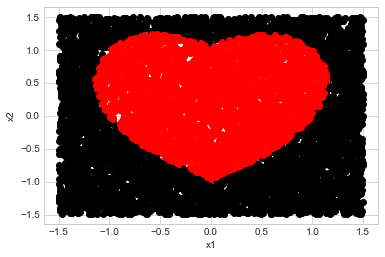

In [21]:
x_black = np.array(d8192[d8192['Outcome']==1]['x1'])
y_black = np.array(d8192[d8192['Outcome']==1]['x2'])
x_red = np.array(d8192[d8192['Outcome']==0]['x1'])
y_red = np.array(d8192[d8192['Outcome']==0]['x2'])

plt.xlabel('x1')
plt.ylabel('x2')

plt.plot(x_black, y_black, 'o', color='black')
plt.plot(x_red, y_red, 'o', color='red')

0.2643805309734514
0.08683628318584069
[9, 17, 45, 103, 239]
[0.2643805309734514, 0.08683628318584069, 0.06415929203539827, 0.02488938053097345, 0.015486725663716783]


Text(0, 0.5, 'error_n')

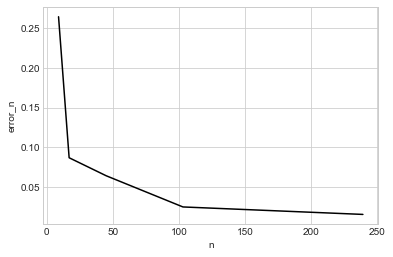

In [22]:
#SK LEARN
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np


df = pd.read_csv("Dbig.txt", sep=" ", header=None)
df.columns = ['x1', 'x2', 'Outcome']
cols = df.columns   
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')


dbig_train = df.sample(n=8192)
df_test = df.loc[~df.index.isin(dbig_train.index)]
d32 = dbig_train[:32]
d128 = dbig_train[:128]
d512 = dbig_train[:512]
d2048 = dbig_train[:2048]
d8192 = dbig_train[:8192]



clf = DecisionTreeClassifier(criterion="entropy")

x_32 = d32.drop(columns='Outcome')
y_32 = d32['Outcome']

x_128 = d128.drop(columns='Outcome')
y_128 = d128['Outcome']

x_512 = d512.drop(columns='Outcome')
y_512 = d512['Outcome']

x_2048 = d2048.drop(columns='Outcome')
y_2048 = d2048['Outcome']

x_8192 = d8192.drop(columns='Outcome')
y_8192 = d8192['Outcome']

model_32 = clf.fit(x_32, y_32)
node_cnt_32 = clf.tree_.node_count
x_test_32 = df_test.drop(columns='Outcome')
y_test_32 = df_test['Outcome']
err_32 = 1- model_32.score(x_test_32, y_test_32)
print(err_32)

model_128 = clf.fit(x_128, y_128)
node_cnt_128 = clf.tree_.node_count
x_test_128 = df_test.drop(columns='Outcome')
y_test_128 = df_test['Outcome']
err_128 = 1- model_128.score(x_test_128, y_test_128)
print(err_128)

model_512 = clf.fit(x_512, y_512)
node_cnt_512 = clf.tree_.node_count
x_test_512 = df_test.drop(columns='Outcome')
y_test_512 = df_test['Outcome']
err_512 = 1- model_512.score(x_test_512, y_test_512)

model_2048 = clf.fit(x_2048, y_2048)
node_cnt_2048 = clf.tree_.node_count
x_test_2048 = df_test.drop(columns='Outcome')
y_test_2048 = df_test['Outcome']
err_2048 = 1- model_2048.score(x_test_2048, y_test_2048)

model_8192 = clf.fit(x_8192, y_8192)
node_cnt_8192 = clf.tree_.node_count
x_test_8192 = df_test.drop(columns='Outcome')
y_test_8192 = df_test['Outcome']
err_8192 = 1- model_8192.score(x_test_8192, y_test_8192)






n = [node_cnt_32, node_cnt_128, node_cnt_512, node_cnt_2048, node_cnt_8192]
print(n)
err = [err_32, err_128, err_512, err_2048, err_8192]
print(err)
plt.plot(n, err, '', color='black')
plt.xlabel('n')
plt.ylabel('error_n')



In [23]:
#Problem 4
x = (5 - 0) * np.random.random_sample((100,))
y = np.sin(x)

from scipy.interpolate import lagrange
poly = lagrange(x, y)

In [24]:
x_test = (5 - 0) * np.random.random_sample((100,))
y_test = np.sin(x_test)
poly = lagrange(x_test, y_test)

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(poly(x), y))
print(mean_absolute_error(poly(x_test), y_test))

9.780987162946131e+69
1.9517653707822643e+70


In [25]:
noise = np.random.normal(0, 1, 100)
x = (5 - 0) * np.random.random_sample((100,))
x = noise+x
poly = lagrange(x, y)
mean_absolute_error(poly(x), y)

7.042570733453915e+69

In [26]:
x_test = (5 - 0) * np.random.random_sample((100,))
y_test = np.sin(x_test)
poly = lagrange(x_test, y_test)
mean_absolute_error(poly(x_test), y_test)

2.15927911005205e+75

In [27]:
noise = np.random.normal(0, 10, 100)
x = (5 - 0) * np.random.random_sample((100,))
x = noise+x
poly = lagrange(x, y)
mean_absolute_error(poly(x), y)

1.531574171745992e+46

In [28]:
x_test = (5 - 0) * np.random.random_sample((100,))
y_test = np.sin(x_test)
poly = lagrange(x_test, y_test)
mean_absolute_error(poly(x_test), y_test)

4.6067364333401284e+73

In [29]:
noise = np.random.normal(0, 50, 100)
x = (5 - 0) * np.random.random_sample((100,))
x = noise+x
poly = lagrange(x, y)
mean_absolute_error(poly(x), y)

1.4225886967754515e+55

In [30]:
x_test = (5 - 0) * np.random.random_sample((100,))
y_test = np.sin(x_test)
poly = lagrange(x_test, y_test)
mean_absolute_error(poly(x_test), y_test)

6.331756938436494e+76